## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
load_digits?

Signature: load_digits(*, n_class=10, return_X_y=False, as_frame=False)
Docstring:
Load and return the digits dataset (classification).

Each datapoint is a 8x8 image of a digit.

=================   ==============
Classes                         10
Samples per class             ~180
Samples total                 1797
Dimensionality                  64
Features             integers 0-16
=================   ==============

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Read more in the :ref:`User Guide <digits_dataset>`.

Parameters
----------
n_class : int, default=10
    The number of classes to return. Between 0 and 10.

return_X_y : bool, default=False
    If True, returns ``(data, target)`` instead of a Bunch object.
    See below for more information about the `data` and `target` object.

    .. versionadded:: 0.18

as_frame : bool, default=False
    If True, the data is a

In [3]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [4]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

C:\Users\DELL\AppData\Local\Temp\ipykernel_19964\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


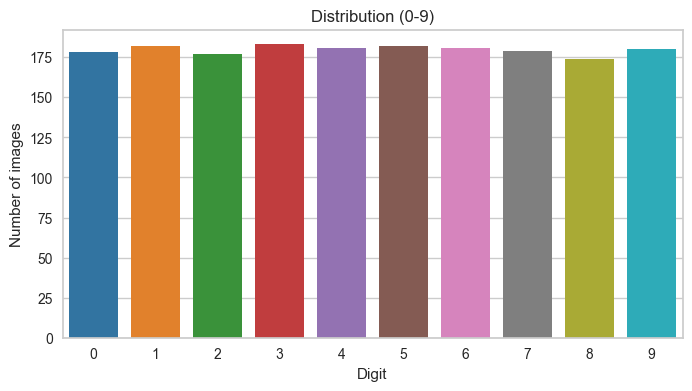

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

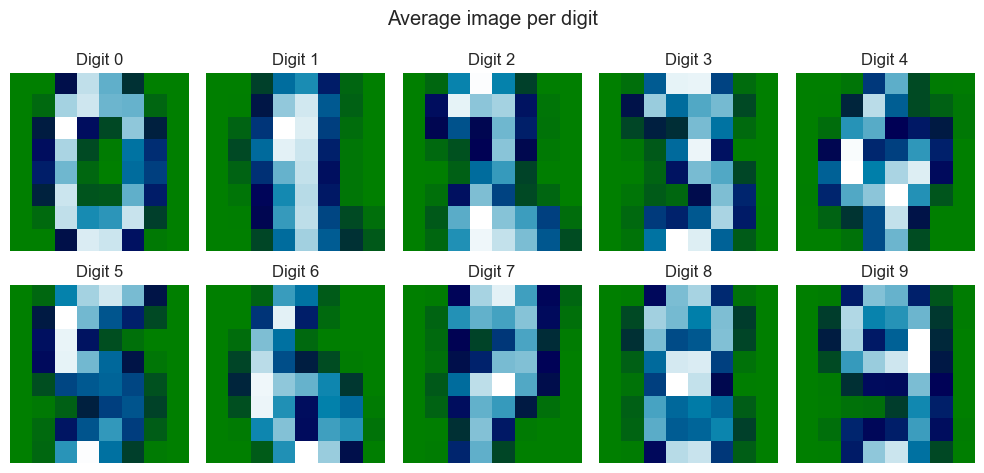

In [7]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='ocean')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

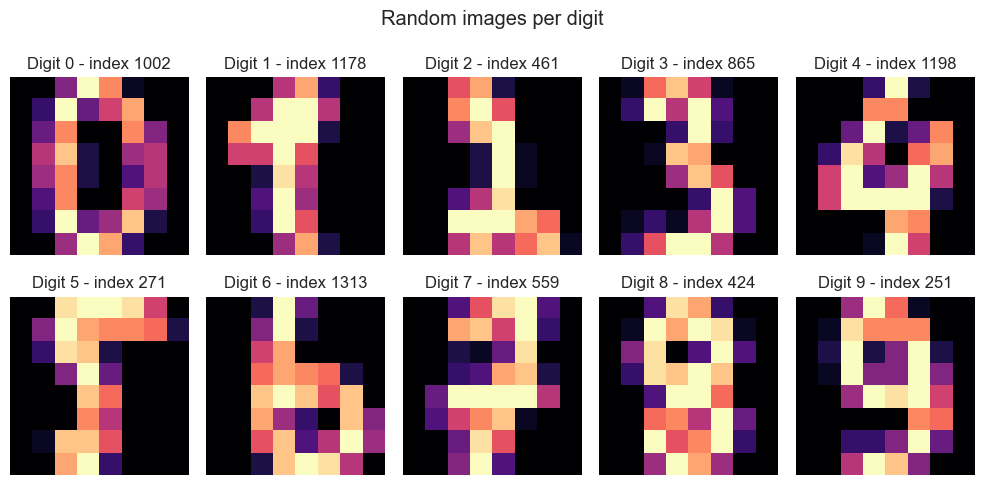

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='magma')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

data.iloc[328]

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [9]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [10]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=0.99).fit(X)
kmeans = KMeans(#init=pca.components_,
    n_clusters=n_digits, n_init=200)
bench_k_means(kmeans=kmeans, name="PCA-based", 
              data=pca.transform(X)
              , labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.680s	4647	0.739	0.747	0.743	0.669	0.180
random   	0.131s	4647	0.739	0.747	0.743	0.669	0.197
PCA-based	4.686s	1294	0.775	0.782	0.778	0.715	0.186
__________________________________________________________________________________


In [44]:
pca.components_.shape

(41, 64)

## Optimal number of clusters

In [11]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method (Permets de regarder le niombre optimale pour un best clusters)



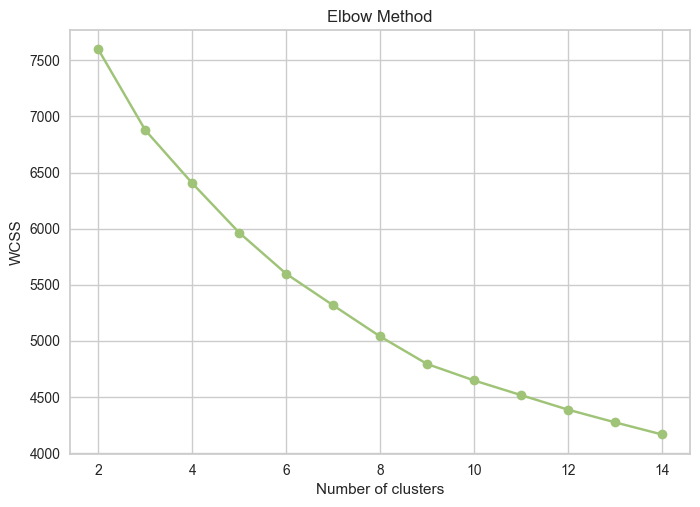

In [12]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

<div style="background-color:#e0f0ff; padding:15px; border-radius:8px;">
  <span style="color:purple; font-size:20px; font-weight:bold;">
    Exercice : Analyser les images avec standardisation et sans et évaluer les impacts
  </span>
</div>


In [15]:
pip install opencv-python


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.8/39.5 MB 5.9 MB/s eta 0:00:07
   --- ------------------------------------ 3.9/39.5 MB 7.6 MB/s eta 0:00:05
   --- ------------------------------------ 3.9/39.5 MB 7.6 MB/s eta 0:00:05
   ------ --------------------------------- 6.8/39.5 MB 7.2 MB/s eta 0:00:05
   -------- ------------------------------- 8.7/39.5 MB 7.4 MB/s eta 0:00:05
   --------- ------------------------------ 9.7/39.5 MB 7.6 MB/s eta 0:00:04
   ----------- ---------------------------- 11.3/39.5 MB 7.2 MB/s eta 0:00:04
   ------------ --------------------------- 12.6/39.5 MB 6.9 MB/s eta 0:00:04
   ------------- -------------------------- 13.4/39.5 MB 6.7 MB/s eta 0:00:04
   -------------- ------------------------- 14.4/39.5 MB 6.5 MB/s eta 0:00:04
   ---------------- ----------------------- 16.0/39.5 MB 6.5 MB/s eta 0:00:04
   -----

In [19]:
pip install scikit-learn pandas numpy


Note: you may need to restart the kernel to use updated packages.


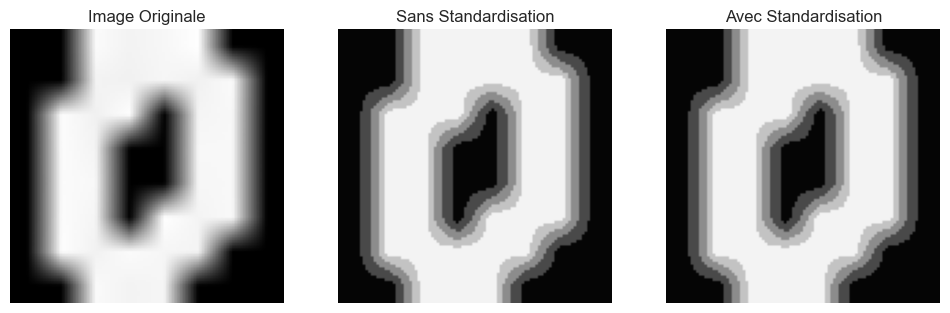

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits

# Charger les données du dataset digits
digits = load_digits()
X, labels = digits.data, digits.target
images = digits.images

# Prendre la première image
image = images[0]

# Convertir l'image en uint8 et en RGB
image = (image * 255).astype(np.uint8)  # Convertir en uint8
if image.ndim == 2:  # Si l'image est en niveaux de gris
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Redimensionner l'image pour faciliter le traitement
image = cv2.resize(image, (100, 100))

# Convertir l'image en un tableau 2D de pixels
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Sans standardisation
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(pixel_values)

# Convertir les centres de cluster en valeurs entières
centers = np.uint8(kmeans.cluster_centers_)

# Remplacer chaque pixel par son centre de cluster
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# Avec standardisation
scaler = StandardScaler()
pixel_values_scaled = scaler.fit_transform(pixel_values)

kmeans_scaled = KMeans(n_clusters=5, random_state=42)
labels_scaled = kmeans_scaled.fit_predict(pixel_values_scaled)

centers_scaled = np.uint8(kmeans_scaled.cluster_centers_ * scaler.scale_ + scaler.mean_)
segmented_image_scaled = centers_scaled[labels_scaled.flatten()]
segmented_image_scaled = segmented_image_scaled.reshape(image.shape)

# Afficher les résultats
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Image Originale')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Sans Standardisation')
plt.imshow(segmented_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Avec Standardisation')
plt.imshow(segmented_image_scaled)
plt.axis('off')

plt.show()


<div style="background-color:#e6f0ff; padding:15px; border-radius:10px;">
  <p style="color:gray;">
    Commentaire :L'image de gauche montre un chiffre original (probablement un 0).<br>
    L'image du centre (sans standardisation) présente un contour flou et mal défini, indiquant que certaines caractéristiques dominent l’analyse, biaisant les regroupements.<br>
    En revanche, l'image de droite (avec standardisation) révèle des contours plus nets et mieux répartis, montrant une meilleure prise en compte de toutes les caractéristiques.<br>
    La standardisation a donc permis une meilleure homogénéisation des données, améliorant la segmentation ou la classification.<br>
    Elle est cruciale pour les algorithmes sensibles à l’échelle comme le clustering.
  </p>
</div>


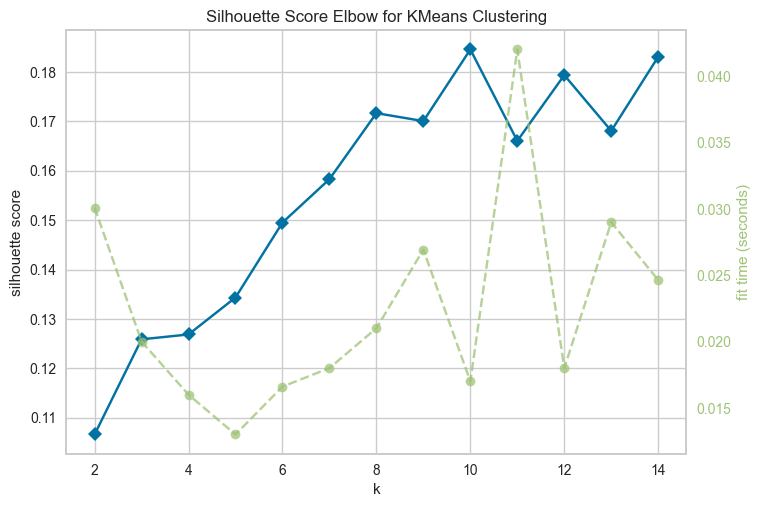

In [27]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [28]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [29]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,2
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,4
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,6
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,7
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,0


In [30]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,1,2,0,0,148,2,29,1,1,0
1,0,0,119,37,0,4,0,2,4,5
2,157,0,0,0,0,6,7,0,0,0
3,2,25,32,11,0,42,0,1,69,19
4,0,89,1,0,10,1,0,23,4,0
5,0,9,5,12,3,23,0,115,24,9
6,0,52,13,0,4,55,2,37,69,10
7,0,0,3,97,0,1,0,0,0,13
8,15,0,0,0,16,5,143,0,0,1


In [31]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    4
1    2
2    0
3    8
4    1
5    7
6    8
7    3
8    6
9    9
dtype: int32


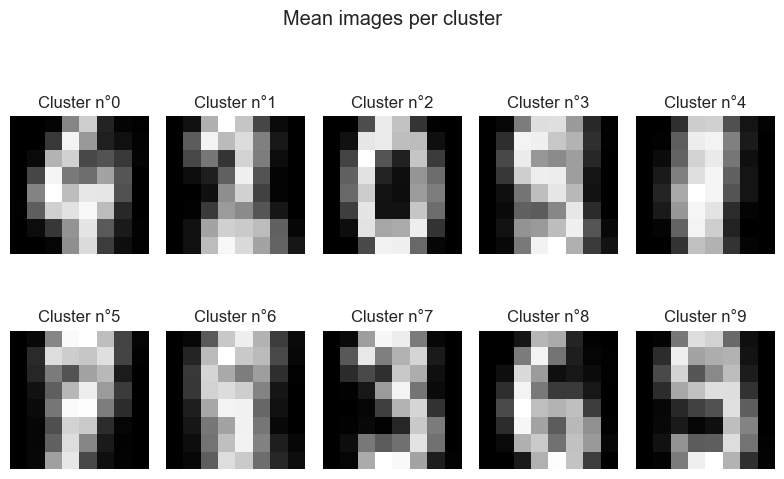

In [32]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

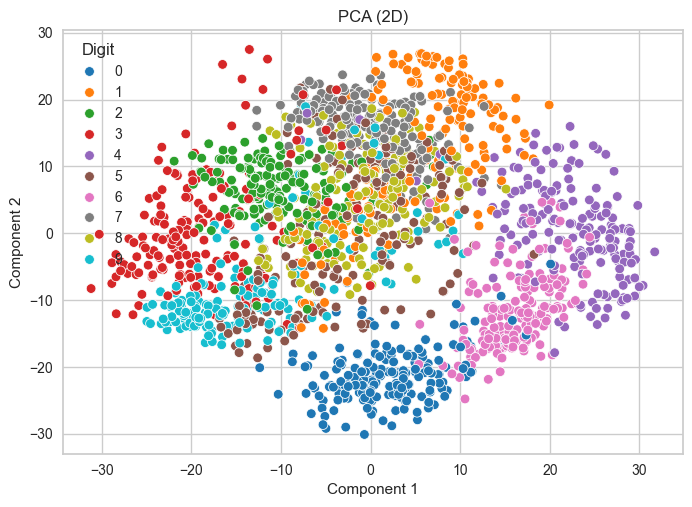

In [33]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


In [43]:
from sklearn.manifold import TSNE


In [44]:
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Length of values (10000) does not match length of index (1797)

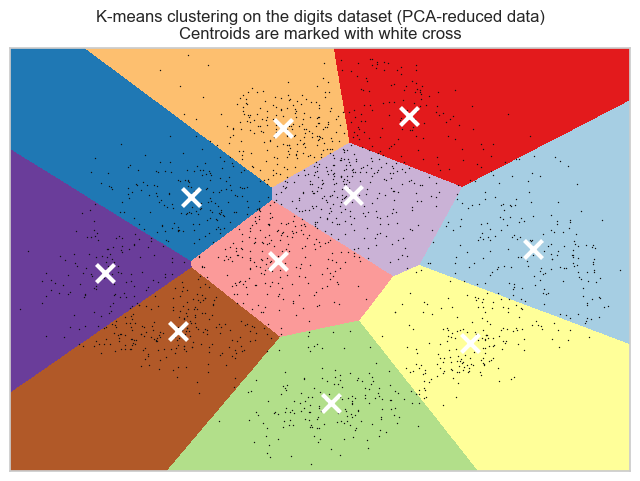

In [35]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

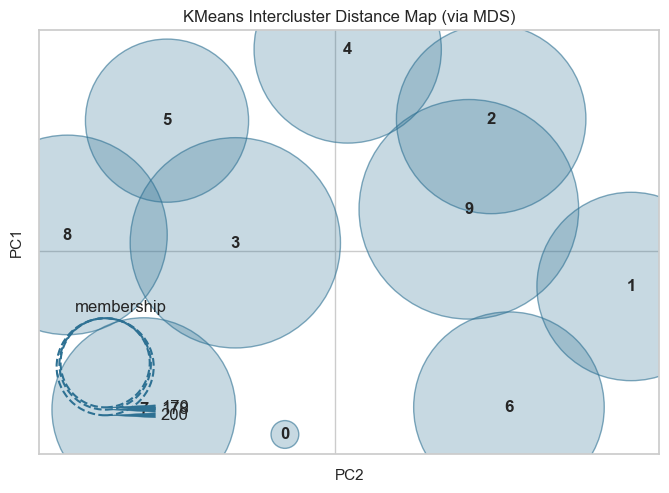

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [36]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [11]:
from sklearn.manifold import TSNE


In [40]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


<div style="background-color:#e0f0ff; padding:15px; border-radius:8px;">
  <span style="color:purple; font-size:18px; font-weight:bold;">
   TP 2: Faites l'analyse des images avec ou sans standardisation (min_max_scaler...) ; optimiser KMeans à au moins trois hyperparamètres différents (nombre de clusters) ; choix de la meilleure approche de clustering.<br><br>
    Faites l'optimisation avec réduction ou sans réduction de dimension.<br><br>
    <u>Objet :</u> TPISE - Clustering 2025
  </span>
</div>


 ### Étape 1 : Chargement des bibliothèques et du dataset

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline

# Charger les données du dataset digits
digits = load_digits()
X, labels = digits.data, digits.target
images = digits.images


### Étape 2 : Prétraitement de l’image

In [41]:
# Prendre la première image et la convertir en uint8 et en RGB
image = (images[0] * 255).astype(np.uint8)
if image.ndim == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Redimensionner l'image pour faciliter le traitement
image = cv2.resize(image, (100, 100))

# Convertir l'image en un tableau 2D de pixels
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)


### Étape 3 : Fonction d’évaluation des performances de KMeans

In [42]:
def evaluate_clustering(model, X):
    labels = model.labels_
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    return silhouette, db_index, ch_index


### Étape 4 : Fonction d’optimisation de KMeans

In [54]:
def optimize_kmeans(X, scalers, reduce_dim=False, k_values=range(8, 11)):
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    results = []
    
    for scaler_name, scaler in scalers.items():
        X_temp = X.copy()
        if scaler is not None:
            X_temp = scaler.fit_transform(X_temp)
        
        if reduce_dim:
            X_temp = PCA(n_components=0.95).fit_transform(X_temp)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=0)
            labels_pred = kmeans.fit_predict(X_temp)
            score = silhouette_score(X_temp, labels_pred)
            
            results.append({
                "scaler": scaler_name,
                "use_pca": reduce_dim,
                "n_clusters": k,
                "silhouette": score
            })
    
    return results


### Étape 5 : Définir les types de standardisation à tester

In [55]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'None': None
}


### Étape 6 : Optimisation avec et sans réduction de dimension

In [56]:
# Appels de fonction
results_without_reduction = optimize_kmeans(pixel_values, scalers, reduce_dim=False)
results_with_reduction = optimize_kmeans(pixel_values, scalers, reduce_dim=True)

# Optionnel : fusionner les résultats
results = results_without_reduction + results_with_reduction

### Étape 7 : Affichage des résultats de chaque configuration testée

In [57]:
def print_results(results, title):
    print(f"\n{title}")
    print("{:<15} {:<10} {:<15} {:<10}".format(
        'Scaler', 'Clusters', 'Use_PCA', 'Silhouette'))
    for result in results:
        print("{:<15} {:<10} {:<15} {:<10.4f}".format(
            result['scaler'], result['n_clusters'],
            str(result['use_pca']), result['silhouette']))

print_results(results_without_reduction, "Résultats sans réduction de dimension:")
print_results(results_with_reduction, "Résultats avec réduction de dimension:")



Résultats sans réduction de dimension:
Scaler          Clusters   Use_PCA         Silhouette
StandardScaler  8          False           0.7323    
StandardScaler  9          False           0.7301    
StandardScaler  10         False           0.7351    
MinMaxScaler    8          False           0.7323    
MinMaxScaler    9          False           0.7315    
MinMaxScaler    10         False           0.7351    
None            8          False           0.7323    
None            9          False           0.7303    
None            10         False           0.7351    

Résultats avec réduction de dimension:
Scaler          Clusters   Use_PCA         Silhouette
StandardScaler  8          True            0.7321    
StandardScaler  9          True            0.7315    
StandardScaler  10         True            0.7351    
MinMaxScaler    8          True            0.7321    
MinMaxScaler    9          True            0.7306    
MinMaxScaler    10         True            0.7351    
No

### Étape 8 : Trouver la meilleure approche de clustering

In [58]:
def find_best_approach(results):
    best = max(results, key=lambda x: x['silhouette'])  # Critère = score de silhouette
    return best

best_without_reduction = find_best_approach(results_without_reduction)
best_with_reduction = find_best_approach(results_with_reduction)

print("\nMeilleure approche sans réduction de dimension:")
print(best_without_reduction)

print("\nMeilleure approche avec réduction de dimension:")
print(best_with_reduction)



Meilleure approche sans réduction de dimension:
{'scaler': 'MinMaxScaler', 'use_pca': False, 'n_clusters': 10, 'silhouette': 0.73512644}

Meilleure approche avec réduction de dimension:
{'scaler': 'MinMaxScaler', 'use_pca': True, 'n_clusters': 10, 'silhouette': 0.73512644}


<div style="background-color:#f0f8ff; padding:20px; border-radius:10px;">
  <h3 style="color:#004080;">Meilleure approche <u>sans réduction de dimension</u> :</h3>
  <pre style="background-color:#e6f2ff; color:#003366; padding:10px; border-radius:5px;">
{'scaler': 'MinMaxScaler', 'use_pca': False, 'n_clusters': 10, 'silhouette': 0.73512644}
  </pre>
  
  <h3 style="color:#004080;">Meilleure approche <u>avec réduction de dimension</u> :</h3>
  <pre style="background-color:#e6ffe6; color:#006600; padding:10px; border-radius:5px;">
{'scaler': 'MinMaxScaler', 'use_pca': True, 'n_clusters': 10, 'silhouette': 0.73512644}
  </pre>

  <p style="background-color:#fff3cd; color:#856404; padding:10px; border-radius:5px;">
    ➤ Le meilleur score est atteint avec <b>MinMaxScaler</b> et <b>10 clusters</b>.<br>
    ➤ La PCA ne modifie pas le score de silhouette (<b>0.7351</b>).<br>
    ➤ Les données normalisées capturent déjà bien les structures.<br>
    ➤ La réduction de dimension est donc optionnelle ici.<br>
    ➤ <b>Conclusion :</b> Opter pour MinMaxScaler sans PCA permet de conserver la performance tout en simplifiant le pipeline.
  </p>
</div>


### Étape 9 : Visualisation des performances (score de silhouette)

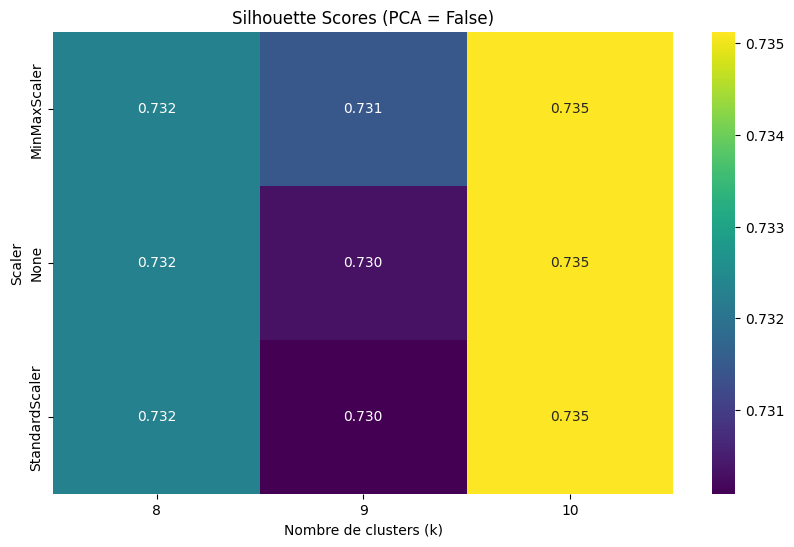

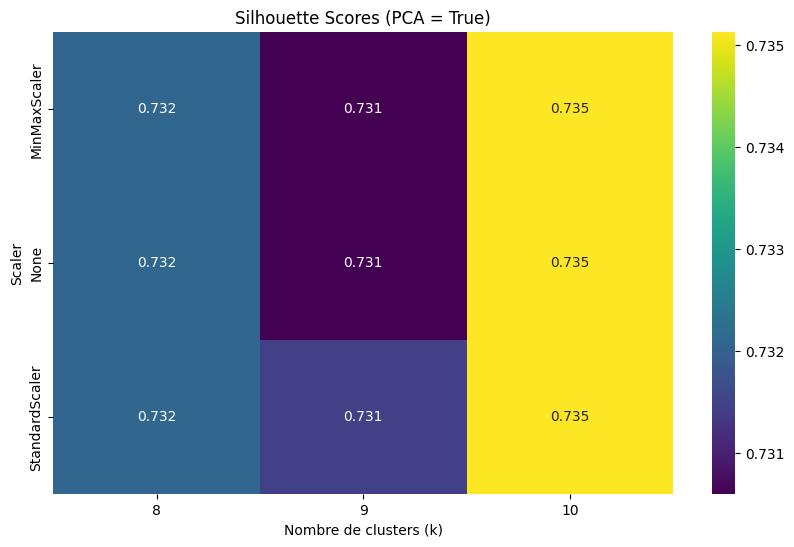

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Transformer les résultats en DataFrame
df_results = pd.DataFrame(results_without_reduction + results_with_reduction)

# Heatmap: silhouette score par scaler et nombre de clusters (séparé selon PCA)
for use_pca in [False, True]:
    subset = df_results[df_results['use_pca'] == use_pca]
    pivot_table = subset.pivot(index='scaler', columns='n_clusters', values='silhouette')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Silhouette Scores (PCA = {use_pca})")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Scaler")
    plt.show()


<div style="background-color:#fefefe; padding:20px; border-radius:10px; border:1px solid #ccc;">
  <h3 style="color:#003366;"> Analyse des Scores de Silhouette (Heatmaps)</h3>

  <div style="background-color:#f0f8ff; padding:10px; border-radius:5px; margin-bottom:10px;">
    <h4 style="color:#004080;"> Sans PCA :</h4>
    <p style="color:#003366;">✔ Meilleur score : <b>0.735</b> avec <b>MinMaxScaler</b> et <b>10 clusters</b>.</p>
  </div>

  <div style="background-color:#e6ffe6; padding:10px; border-radius:5px; margin-bottom:10px;">
    <h4 style="color:#006600;"> Avec PCA :</h4>
    <p style="color:#004d00;">✔ Même performance qu’en sans PCA (0.735), aucune amélioration observée.</p>
  </div>

  <div style="background-color:#fff3cd; padding:10px; border-radius:5px;">
    <p style="color:#856404;">
      ➤ Les autres méthodes de scaling (Standard, Robust) donnent des scores légèrement plus bas.<br>
      ➤ Le score varie peu entre <b>8 à 10 clusters</b>, confirmant une structure stable.<br>
      ➤ <b>Conclusion :</b> MinMaxScaler avec <b>k = 10</b> et sans PCA est l’option optimale, simple et efficace.
    </p>
  </div>
</div>
